# MOVIE STUDIO ANALYSIS

<img src="images/moviedog.jpg" style="width:100%; height:auto;">

## Overview

## Overview 

In this project, we are tackling a critical business challenge for my company as we venture into the competitive world of original video content creation. Recognizing the trend of major companies producing their own content, our leadership has decided to establish a new movie studio. However, we face a significant knowledge gap in the film industry.

Our role is to conduct a comprehensive analysis of the current box office landscape to identify which types of films are performing best. This research is crucial as it will form the foundation of our studio's content strategy. We are tasked with analyzing data and translating our findings into actionable insights.

## Objective 

The ultimate goal of this project is to provide our newly appointed head of the movie studio with data-driven recommendations. These insights will be instrumental in guiding decisions about which types of films to produce, helping us to strategically position our new studio in the market and maximize our chances of box office success.

we will be using the following datasets:
1. `rt.reviews.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
2. `rt.movie_info.tsv` from [rotten tomatoes](https://www.rottentomatoes.com/)
3. `im.db` from [IMDB](https://www.imdb.com/)
4. `tn.movie_budgets.csv` from [NUMBERS](https://www.the-numbers.com/)

### Importing libraries

In [3]:
# importing libraries

import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

%matplotlib inline

### Loading Data sets

In [4]:
# loading datasets

# reviews dataset
file_path = 'data/rt.reviews.tsv'

try:
    review_df = pd.read_csv(file_path, sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')
except pd.errors.ParserError as e:
    print(f"Error parsing file: {e}")

#Loading Movie_Info
movie_info_df = pd.read_csv('data/rt.movie_info.tsv', sep='\t', on_bad_lines='skip', encoding='ISO-8859-1')


# im.dbsqlite, we load only the 2 tables that are needed for the analysis. 
conn = sqlite3.connect('data/im.db')
q = '''
SELECT *
    FROM movie_basics
    JOIN movie_ratings
    ON movie_basics.movie_ID = movie_ratings.movie_id
'''
imdb_df = pd.read_sql(q, conn)

# Loading 'The Numbers' Dataset
path = 'data/tn.movie_budgets.csv'
movie_budgets_df = pd.read_csv(path)


In [5]:
#closing the database cinnectiom
conn.close()

## Data understanding

The dataset consists of multiple sources providing various perspectives on movies. The review_df captures movie reviews with columns such as `id, review, rating, fresh, critic, top_critic, publisher, and date`. This data includes reviewer comments, ratings, and the nature of the review (fresh or rotten), along with details about the critic and publication date, enabling analysis of review trends and critic influence.

The movieinfo_df provides detailed movie information, including `id, synopsis, rating (target audience), genre, director, writer, theatre date, dvd date, currency, box office, runtime, and studio`. This data allows for examination of movie content, production details, and performance, with information on plot summaries, target audiences, genres, key personnel, release dates, and box office revenues.

The movie_budgets_df datasets offer financial insights. movie_budgets_df contains `id, release date, movie, production_budget, domestic gross, and worldwide gross`, providing data on production costs and revenue. Additionally, the im.db_df from a SQL database includes structured movie attributes and ratings. Together, these datasets facilitate a comprehensive analysis of movie performance, financial success, and audience reception.

## DATA CLEANING

#### 1.1. Merging review_df and Movie_info_df
    The two datasets are from rotten tomatoes and they have common feature `id` to help us merge the datasets

In [6]:
#merge the two dfs
merged_df = pd.merge(review_df, movie_info_df, on='id', how='inner')

#### 1.2 Dropping columns not used

In [7]:
# columns to drop
columns_to_drop =['review', 'critic', 'top_critic', 'publisher', 'synopsis', 'writer', 'studio', 'currency', 'box_office']

merged_df = merged_df.drop(columns_to_drop, axis=1)

#### 1.3 Changing column names for rating_x (star_rating) and rating_y(MPAA_rating)

In [8]:
merged_df.rename(columns={'rating_x': 'star_rating', 'rating_y': 'MPAA_rating'}, inplace=True)
merged_df.head()

,id,star_rating,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime
0,3,3/5,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
1,3,NaN,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
2,3,NaN,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
3,3,NaN,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes
4,3,NaN,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108 minutes


#### 1.4 checking and Dealing with missing values

In [9]:
merged_df.isna().sum()

id                  0
star_rating     13517
fresh               0
date                0
MPAA_rating        86
genre              87
director         5440
theater_date     1226
dvd_date         1226
runtime           838
dtype: int64

#### 1.5 Standardizing star_rating
to make the standardized values to have a common rate of 10

In [10]:
# Function to convert star ratings to a 0-10 scale
def convert_rating(rating):
    if pd.isna(rating):
        return np.nan
    
    # Handle mixed fractions (e.g., '3 1/2')
    if ' ' in rating and '/' in rating:
        whole, frac = rating.split(' ')
        num, denom = frac.split('/')
        return (float(whole) + float(num) / float(denom)) * 10 / (10 / float(denom))
    
    # Convert fraction ratings (e.g., '3/5')
    if '/' in rating:
        num, denom = rating.split('/')
        num = float(num)
        denom = float(denom)
        return (num / denom) * 10
    
    # Convert letter grades
    letter_grades = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 2.5, 'F+': 2, 'F-': 1.5
    }
    if rating in letter_grades:
        return letter_grades[rating]
    
    # Handle unconventional ratings ('N', 'R', etc.)
    unconventional_ratings = {
        'N': np.nan, 'R': np.nan  # Treat as missing values or set specific values
    }
    if rating in unconventional_ratings:
        return unconventional_ratings[rating]
    
    # Convert direct numeric ratings if within the range
    try:
        value = float(rating)
        if 0 <= value <= 10:
            return value
    except ValueError:
        pass
    
    return np.nan

# Apply conversion function to the star_rating column
merged_df['standardized_rating'] = merged_df['star_rating'].apply(convert_rating)

# Display the DataFrame with standardized ratings
# merged_df

#### 1.5.1 fill missing standardized rating with mean

In [11]:
# fill standardized_rating with mean

merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean(), inplace=True)

C:\Users\Floyed\AppData\Local\Temp\ipykernel_14252\3497875837.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['standardized_rating'].fillna(merged_df['standardized_rating'].mean(), inplace=True)


In [12]:
# drop rows with missing values on columns `MPAA_rating` and `genre`
merged_df = merged_df.dropna(subset=['MPAA_rating', 'genre'])

In [13]:
# Drop the star_rating column because we have standardized rating

merged_df = merged_df.drop('star_rating', axis=1)

#### 1.6 checking and dropping duplicates

In [14]:
# checking duplicates
duplicate_rows = merged_df[merged_df.duplicated()]

#dropping duplicates
merged_df = merged_df.drop_duplicates()

In [15]:
merged_df.isna().sum()

id                        0
fresh                     0
date                      0
MPAA_rating               0
genre                     0
director               4105
theater_date            954
dvd_date                954
runtime                 471
standardized_rating       0
dtype: int64

#### 1.7 handling missing values for director, theatre date, dvd_date, runtime

In [16]:
# 1. Drop rows with missing values in specific columns
merged_df.dropna(subset=['theater_date', 'dvd_date'], inplace=True)

# 2. Fill with specific values
merged_df['director'].fillna('Unknown', inplace=True)

C:\Users\Floyed\AppData\Local\Temp\ipykernel_14252\3538672782.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['director'].fillna('Unknown', inplace=True)


#### 1.8 extract minutes in the runtime dataset

In [17]:
# extract minutes in the runtime dataset
merged_df['runtime'] = merged_df['runtime'].str.extract('(\d+)').astype(float)

# fill the missing runtime values with the mean
merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)

C:\Users\Floyed\AppData\Local\Temp\ipykernel_14252\3809561258.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['runtime'].fillna(merged_df['runtime'].mean(), inplace=True)


In [18]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39453 entries, 0 to 54431
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   39453 non-null  int64  
 1   fresh                39453 non-null  object 
 2   date                 39453 non-null  object 
 3   MPAA_rating          39453 non-null  object 
 4   genre                39453 non-null  object 
 5   director             39453 non-null  object 
 6   theater_date         39453 non-null  object 
 7   dvd_date             39453 non-null  object 
 8   runtime              39453 non-null  float64
 9   standardized_rating  39453 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 3.3+ MB


In [19]:
merged_df.head()

,id,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime,standardized_rating
0,3,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.000000
1,3,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708
2,3,fresh,"January 4, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708
3,3,fresh,"November 16, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708
4,3,fresh,"October 12, 2017",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708


### 2. movie_budgets_df 

In [20]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


#### 2.1 checking for null values

In [21]:
movie_budgets_df.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

#### 2.2 checking for duplicates

In [22]:
#  checking duplicates

duplicated_rows = movie_budgets_df[movie_budgets_df.duplicated()]
duplicated_rows

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


#### 2.3 standardizing date time and removing the dolar sign from the `production_budget` and other cash columns

In [23]:
# Convert 'release_date' to datetime
movie_budgets_df['release_date'] = pd.to_datetime(movie_budgets_df['release_date'])

# Function to remove dollar signs and commas and convert to numeric
def clean_currency(column):
    return column.replace('[\$,]', '', regex=True).astype(float)

# Apply the function to the budget and gross columns
movie_budgets_df['production_budget'] = clean_currency(movie_budgets_df['production_budget'])
movie_budgets_df['domestic_gross'] = clean_currency(movie_budgets_df['domestic_gross'])
movie_budgets_df['worldwide_gross'] = clean_currency(movie_budgets_df['worldwide_gross'])

movie_budgets_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09
2,3,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08
3,4,2015-05-01,Avengers: Age of Ultron,330600000.0,459005868.0,1.403014e+09
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000.0,620181382.0,1.316722e+09
...,...,...,...,...,...,...
5777,78,2018-12-31,Red 11,7000.0,0.0,0.000000e+00
5778,79,1999-04-02,Following,6000.0,48482.0,2.404950e+05
5779,80,2005-07-13,Return to the Land of Wonders,5000.0,1338.0,1.338000e+03
5780,81,2015-09-29,A Plague So Pleasant,1400.0,0.0,0.000000e+00


### 3. imdb data set

In [24]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   movie_id         73856 non-null  object 
 7   averagerating    73856 non-null  float64
 8   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 5.1+ MB


#### 3.1 checking for duplicates

In [25]:
# checking duplicates

dup_rows = imdb_df[imdb_df.duplicated]
dup_rows

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes


#### 3.2 checking and dealing with null

In [26]:
# drop null values on runtime and genres rows

imdb_df = imdb_df.dropna(subset = ['runtime_minutes', 'genres'], )

In [27]:
imdb_df.isna().sum()

movie_id           0
primary_title      0
original_title     0
start_year         0
runtime_minutes    0
genres             0
movie_id           0
averagerating      0
numvotes           0
dtype: int64

### Visualization

#### 1. Univariate

##### plot `fresh` from `merge_df` distribution

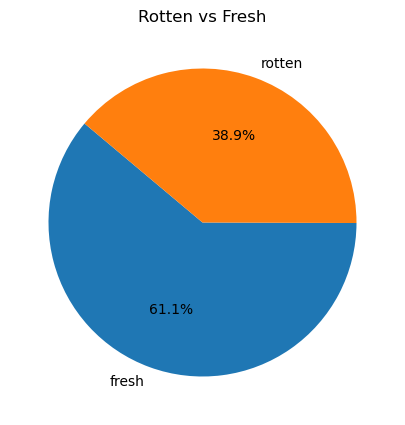

In [28]:
frequencies = merged_df['fresh'].value_counts()

# Plotting the pie chart
plt.figure(figsize=(8, 5))
plt.pie(frequencies, labels=frequencies.index, autopct='%1.1f%%', startangle=140)
plt.title('Rotten vs Fresh')
plt.show()

#### plot of cost distribution 

c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


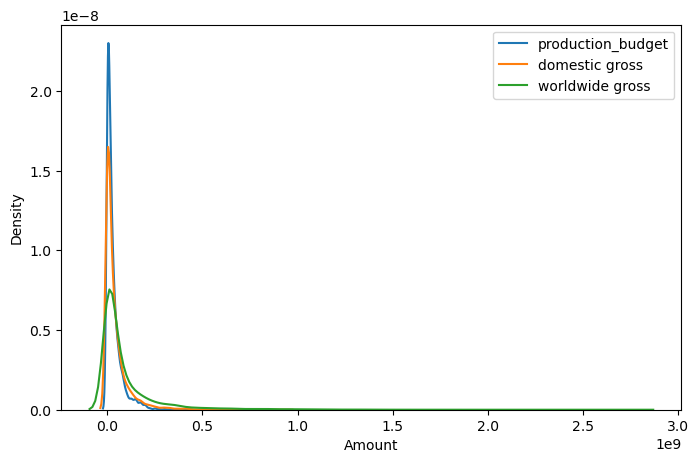

In [29]:
plt.figure(figsize=(8, 5))
sns.kdeplot(movie_budgets_df['production_budget'], label='production_budget')
sns.kdeplot(movie_budgets_df['domestic_gross'], label='domestic gross')
sns.kdeplot(movie_budgets_df['worldwide_gross'], label='worldwide gross')
plt.xlabel('Amount')
plt.legend()
plt.show()

###  `imdb` data analysis

In [30]:
imdb_df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,movie_id,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",tt0063540,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",tt0066787,7.2,43


#### checking genre combinations

In [31]:
imdb_df['genres'].unique()

array(['Action,Crime,Drama', 'Biography,Drama', 'Drama',
       'Comedy,Drama,Fantasy', 'Adventure,Animation,Comedy', 'History',
       'Documentary', 'Animation,Drama,History', 'Drama,Mystery',
       'Action,Animation,Comedy', 'Biography,Comedy,Drama',
       'Action,Drama', 'Documentary,History', 'Sci-Fi', 'Comedy',
       'Thriller', 'Adventure,Animation,Sci-Fi', 'Drama,Horror',
       'Drama,Mystery,Thriller', 'Drama,Family',
       'Adventure,Comedy,Romance', 'Comedy,Drama',
       'Adventure,Drama,Romance', 'Biography', 'Horror',
       'Adventure,Comedy,Drama', 'Drama,Sci-Fi,Thriller', 'Action',
       'Comedy,Drama,Romance', 'Action,Adventure,Sci-Fi', 'Crime,Drama',
       'Comedy,Family', 'Adventure', 'Drama,History,War',
       'Action,Thriller', 'Comedy,Crime', 'Crime,Drama,Thriller',
       'Action,Sci-Fi,Thriller', 'Fantasy', 'Drama,Mystery,Sci-Fi',
       'Biography,Drama,History', 'Action,Comedy,Crime',
       'Action,Adventure,Thriller', 'Horror,Mystery,Thriller',
    

#### Normalize and tokenize genre strings to analyze the combinations

In [32]:
# Normalize genre strings - making them of same of same category, lowecase
imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Expand genres into separate columns
genres_expanded = imdb_df['genres_list'].explode().unique()
for genre in genres_expanded:
    imdb_df[genre] = imdb_df['genres_list'].apply(lambda x: 1 if genre in x else 0)

# Drop the intermediate columns
df = imdb_df.drop(columns=['genres', 'genres_list'])

df.head(2)

,movie_id,primary_title,original_title,start_year,runtime_minutes,movie_id,averagerating,numvotes,action,crime,...,war,music,sport,western,musical,news,reality-tv,game-show,adult,short
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,tt0063540,7.0,77,1,1,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,tt0066787,7.2,43,0,0,...,0,0,0,0,0,0,0,0,0,0


#### genre frequency distribution

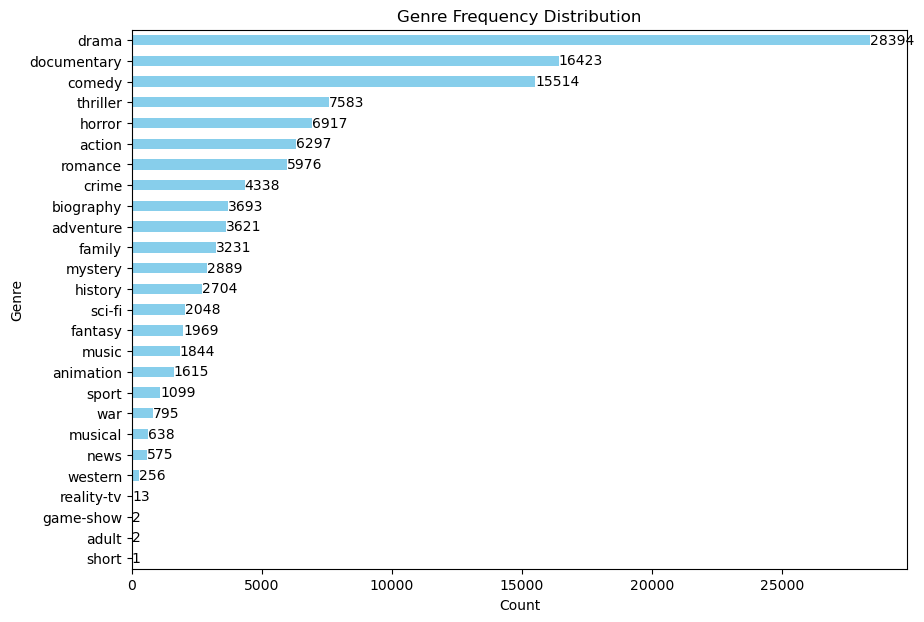

In [33]:
#Frequency count

# Count the frequency of each genre
genre_counts = df[genres_expanded].sum()

# Plot the distribution
plt.figure(figsize=(10, 7))
ax = genre_counts.sort_values().plot(kind='barh', color='skyblue')

# Add count labels next to each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(width + 0.1, p.get_y() + p.get_height() / 2, int(width), 
            ha='left', va='center', color='black')

plt.title('Genre Frequency Distribution')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()


#### Genre combinations co-occurrence - heatmap

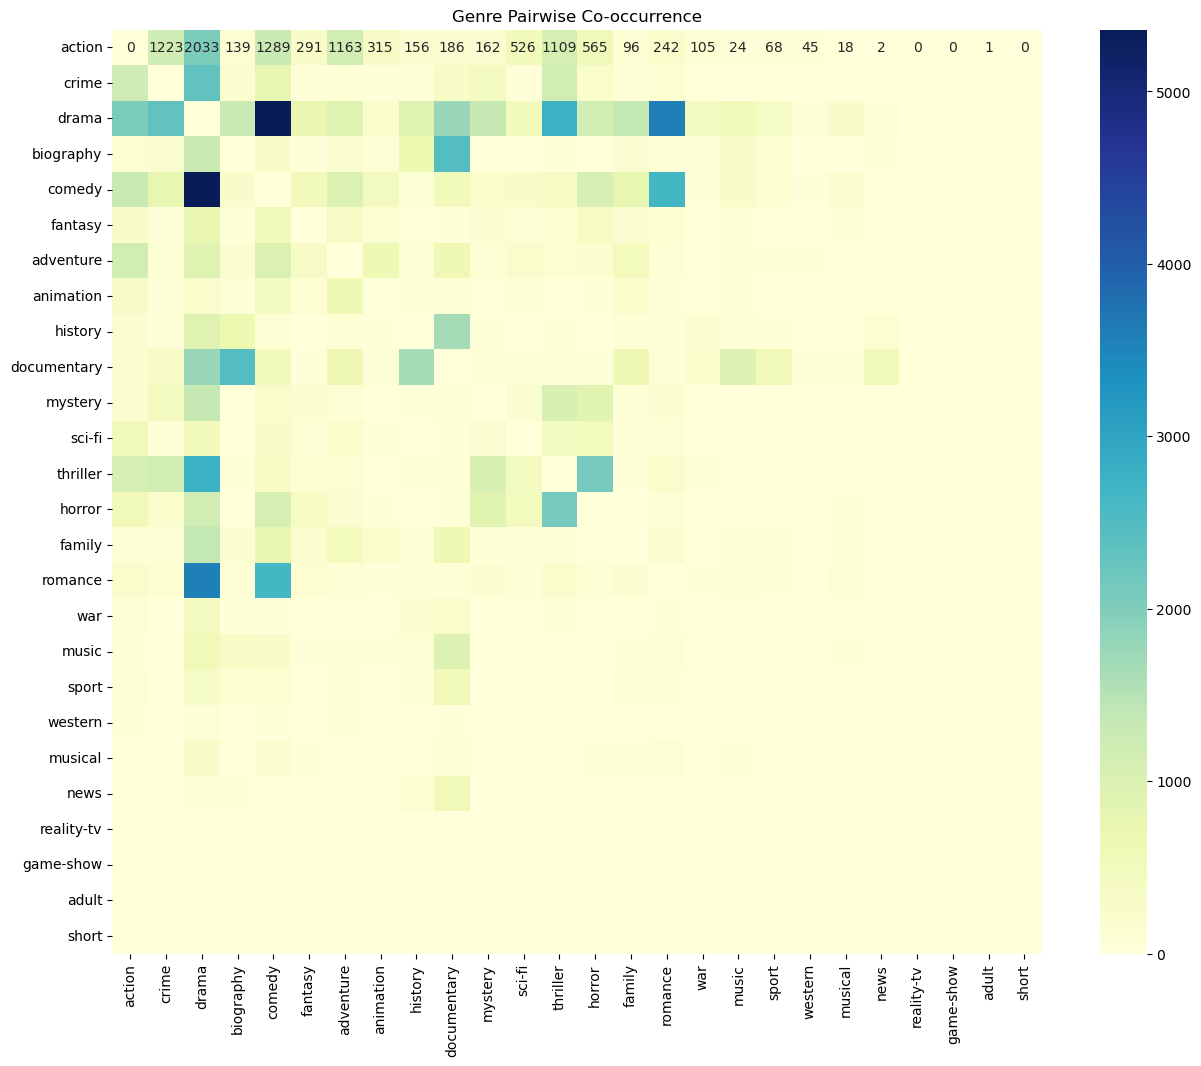

In [34]:
# Create a DataFrame for pairwise genre combinations
from itertools import combinations

# Calculate pairwise genre co-occurrence
genre_pairs = pd.DataFrame(
    index=genres_expanded,
    columns=genres_expanded,
    data=0
)

for genre1, genre2 in combinations(genres_expanded, 2):
    genre_pairs.loc[genre1, genre2] = ((df[genre1] & df[genre2]).sum())
    genre_pairs.loc[genre2, genre1] = genre_pairs.loc[genre1, genre2]

# Plot the pairwise co-occurrence
plt.figure(figsize=(15, 12))
sns.heatmap(genre_pairs, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Genre Pairwise Co-occurrence')
plt.show()


#### genre occurence and combinations count

In [35]:
# Normalize genre strings
#imdb_df['genres'] = imdb_df['genres'].str.strip().str.lower()

# Tokenize genres
#imdb_df['genres_list'] = imdb_df['genres'].str.split(',')

# Create a DataFrame to store genre combinations
genre_combinations = pd.DataFrame(columns=['Combination', 'Count'])

# Generate genre combinations for each movie and count occurrences
combination_counts = {}

for _, row in imdb_df.iterrows():
    genres = sorted(row['genres_list'])  # Sort genres to ensure order consistency
    for r in range(1, len(genres) + 1):
        for combo in combinations(genres, r):
            combo_str = ' & '.join(combo)
            if combo_str in combination_counts:
                combination_counts[combo_str] += 1
            else:
                combination_counts[combo_str] = 1

# Convert the combination counts dictionary to a DataFrame
genre_combinations = pd.DataFrame(list(combination_counts.items()), columns=['Combination', 'Count'])

# Sort by Count in descending order
result_table = genre_combinations.sort_values(by='Count', ascending=False)

# Print the sorted table
print("Genre Combination Counts:")
print(result_table)

Genre Combination Counts:
                          Combination  Count
2                               drama  28394
22                        documentary  16423
9                              comedy  15514
36                           thriller   7583
40                             horror   6917
..                                ...    ...
798             drama & war & western      1
800        adventure & music & sci-fi      1
802        biography & family & sport      1
804  action & animation & documentary      1
966     documentary & family & sci-fi      1

[967 rows x 2 columns]


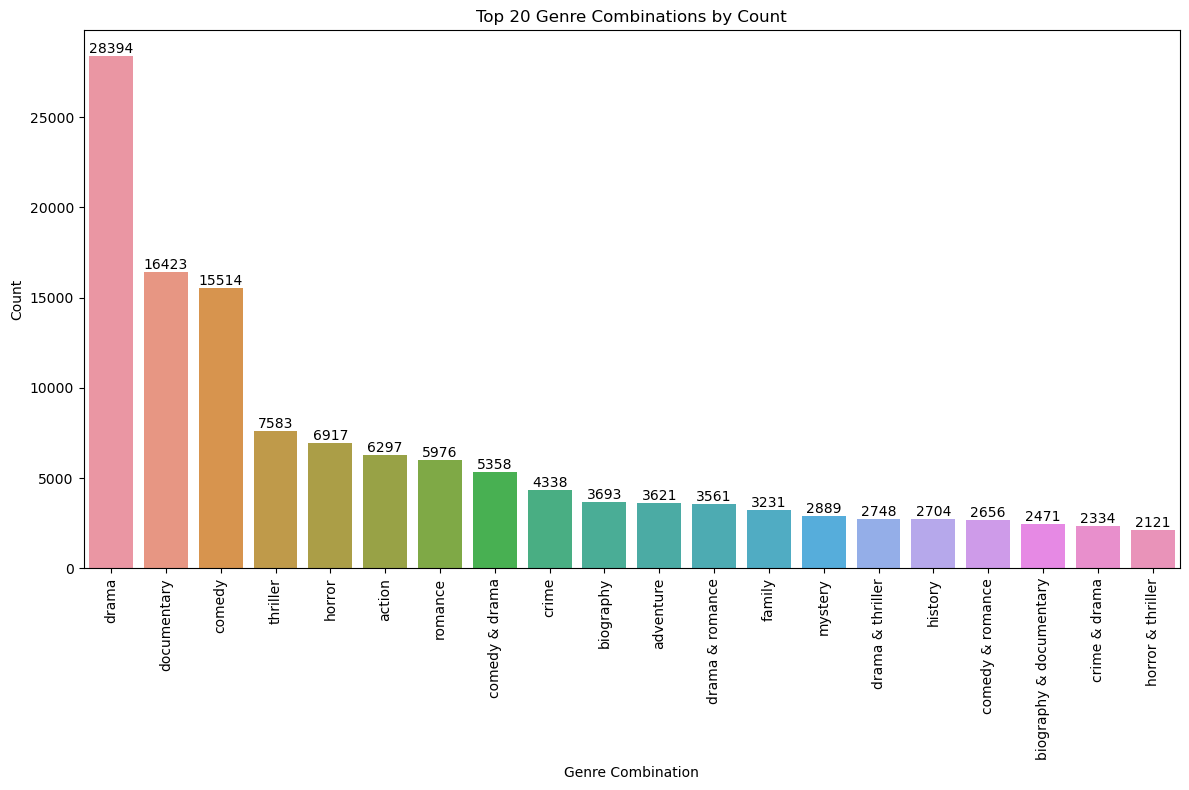

In [36]:
# Create DataFrame and select top 20 rows
result = pd.DataFrame(result_table)
result = result.head(20)

# Plotting the bar plot
plt.figure(figsize=(12, 8))
sns.barplot(x=result['Combination'], y=result['Count'])

# Adding annotations (count values) on top of each bar
for index, value in enumerate(result['Count']):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title('Top 20 Genre Combinations by Count')
plt.xlabel('Genre Combination')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

## Movie_Budgets_df Analysis

In [37]:
movie_budgets_df.head(2)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000.0,760507625.0,2.776345e+09
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09


In [38]:
movie_budgets_df.describe()

,id,release_date,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5782,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,2004-07-06 05:20:31.546177792,3.158776e+07,4.187333e+07,9.148746e+07
min,1.000000,1915-02-08 00:00:00,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,2000-04-22 18:00:00,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,2007-03-02 00:00:00,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,2012-12-25 00:00:00,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,2020-12-31 00:00:00,4.250000e+08,9.366622e+08,2.776345e+09
std,28.821076,NaN,4.181208e+07,6.824060e+07,1.747200e+08


In [39]:
movie_budgets_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr()

,production_budget,domestic_gross,worldwide_gross
production_budget,1.000000,0.685682,0.748306
domestic_gross,0.685682,1.000000,0.938853
worldwide_gross,0.748306,0.938853,1.000000


Correlation Analysis:

1. Production Budget vs Domestic Gross: 0.686
   - Moderately strong positive correlation
   - Higher budgets tend to yield higher domestic earnings

2. Production Budget vs Worldwide Gross: 0.748
   - Stronger positive correlation than domestic
   - Big budgets have more impact on global earnings

3. Domestic Gross vs Worldwide Gross: 0.939
   - Very strong positive correlation
   - Domestic success strongly indicates global success

Key Insights from this analysis:

1. Budget Impact: Higher budgets are associated with higher earnings, both domestically and worldwide. The stronger correlation with worldwide gross suggests that big-budget movies might have more international appeal or marketing reach.
2. Domestic performance is a good predictor of global performance. Domestic-Worldwide relationship: The very strong correlation between domestic and worldwide gross implies that domestic performance is a good indicator of global performance. This could be due to factors like marketing strategies that work well across markets or the global influence of the US film market.
3. Budget isn't the only factor; While there's a positive correlation between budget and earnings, it's not perfect. This suggests that other factors (like quality, marketing, timing, etc.) play significant roles in a movie's financial success.
4. Worldwide potential: The stronger correlation between budget and worldwide gross (compared to domestic gross) might indicate that higher budgets are particularly beneficial for international appeal, perhaps due to more spectacular visual effects, bigger stars, or larger marketing campaigns that resonate globally.

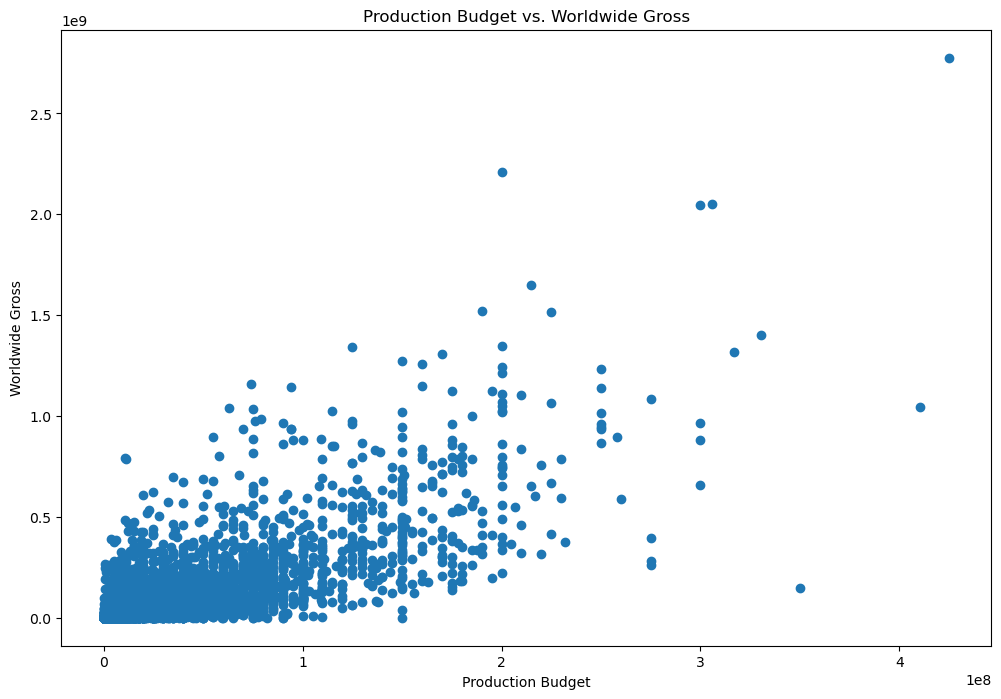

In [40]:
plt.figure(figsize=(12, 8))
plt.scatter(movie_budgets_df['production_budget'], movie_budgets_df['worldwide_gross'])
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')
plt.title('Production Budget vs. Worldwide Gross')
plt.show()

In [41]:
top_grossing = movie_budgets_df.sort_values('worldwide_gross', ascending=False).head(10)
print(top_grossing[['movie', 'worldwide_gross']])

                                             movie  worldwide_gross
0                                           Avatar     2.776345e+09
42                                         Titanic     2.208208e+09
5             Star Wars Ep. VII: The Force Awakens     2.053311e+09
6                           Avengers: Infinity War     2.048134e+09
33                                  Jurassic World     1.648855e+09
66                                       Furious 7     1.518723e+09
26                                    The Avengers     1.517936e+09
3                          Avengers: Age of Ultron     1.403014e+09
41                                   Black Panther     1.348258e+09
260  Harry Potter and the Deathly Hallows: Part II     1.341693e+09


In [42]:
top_grossing = movie_budgets_df.sort_values('worldwide_gross', ascending=False).head(10)
top_grossing[['movie', 'worldwide_gross']]
movie_budgets_df['ROI'] = (movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']) / movie_budgets_df['production_budget']
top_roi = movie_budgets_df.sort_values('ROI', ascending=False).head(10)
print(top_roi[['movie', 'ROI']])

                         movie          ROI
5745               Deep Throat  1799.000000
5613                   Mad Max   497.750000
5492       Paranormal Activity   430.517853
5679               The Gallows   415.564740
5406   The Blair Witch Project   412.833333
5709             Super Size Me   341.058585
5346                     Bambi   311.354312
5773               El Mariachi   290.704000
5676  Night of the Living Dead   262.921614
5210                     Rocky   224.000000


In [43]:
# Average budget and gross by year

# Function to clean currency and handle potential errors
def clean_currency(x):
    if isinstance(x, str):
        try:
            return float(x.replace('$', '').replace(',', ''))
        except ValueError:
            return np.nan
    return x if pd.notnull(x) else np.nan

# Clean the monetary columns
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']
for col in columns_to_clean:
    movie_budgets_df[col] = movie_budgets_df[col].apply(clean_currency)
    movie_budgets_df[col] = pd.to_numeric(movie_budgets_df[col], errors='coerce')

# Convert release_date to datetime and extract the year
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year

# Calculate yearly averages
yearly_avg = movie_budgets_df.groupby('year')[columns_to_clean].mean()
print(yearly_avg)

      production_budget  domestic_gross  worldwide_gross
year                                                    
1915       1.100000e+05    1.000000e+07     1.100000e+07
1916       2.929535e+05    4.000000e+06     4.000000e+06
1920       1.000000e+05    3.000000e+06     3.000000e+06
1925       2.072500e+06    1.000000e+07     1.550000e+07
1927       2.000000e+06    0.000000e+00     0.000000e+00
...                 ...             ...              ...
2016       4.097370e+07    5.042387e+07     1.313614e+08
2017       5.003073e+07    6.222259e+07     1.692240e+08
2018       4.813886e+07    7.378870e+07     1.824786e+08
2019       5.273896e+07    4.280029e+07     9.965411e+07
2020       9.400000e+07    0.000000e+00     0.000000e+00

[96 rows x 3 columns]


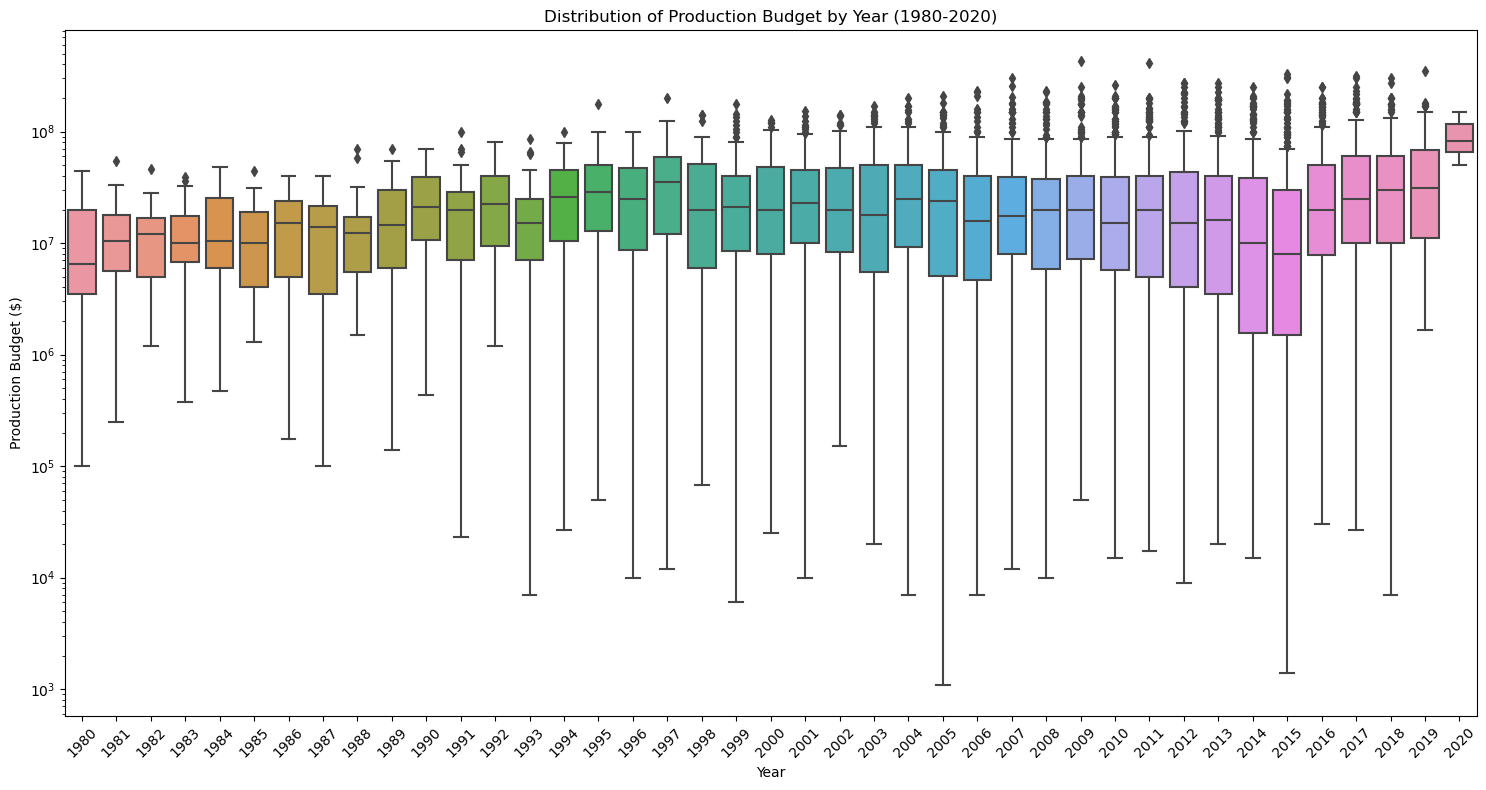

In [44]:
# Ensure the year and production_budget are in the correct format
movie_budgets_df['year'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.year
movie_budgets_df['production_budget'] = pd.to_numeric(movie_budgets_df['production_budget'], errors='coerce')

# Filter the dataframe for years 1980-2020
filtered_df = movie_budgets_df[(movie_budgets_df['year'] >= 1980) & (movie_budgets_df['year'] <= 2020)]

# Create the plot
plt.figure(figsize=(15, 8))
sns.boxplot(x='year', y='production_budget', data=filtered_df)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Production Budget ($)')
plt.title('Distribution of Production Budget by Year (1980-2020)')

# Use log scale for y-axis due to wide range of budget values
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

#### Average profit by month of the year

c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Floyed\anaconda3\envs\learn-env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


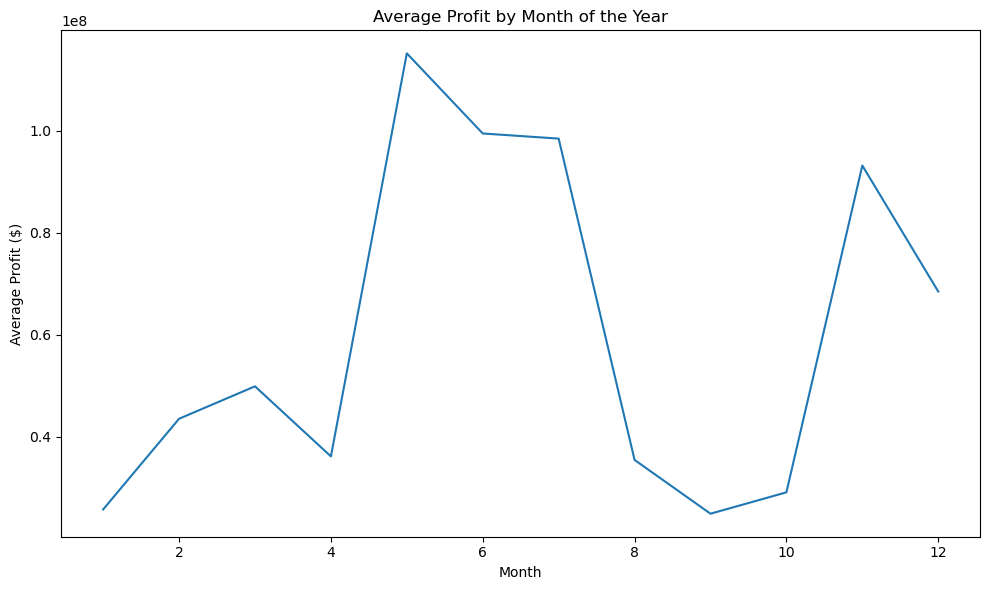

In [45]:
# Extract the month from the release_date column
movie_budgets_df['month'] = pd.to_datetime(movie_budgets_df['release_date'], errors='coerce').dt.month

# Calculate the profit for each movie
movie_budgets_df['profit'] = movie_budgets_df['worldwide_gross'] - movie_budgets_df['production_budget']

# Calculate the average profit by month
monthly_avg_profit = movie_budgets_df.groupby('month')['profit'].mean()

# Create the line graph
plt.figure(figsize=(10, 6))
sns.lineplot(x=monthly_avg_profit.index, y=monthly_avg_profit.values)

# Set labels and title
plt.xlabel('Month')
plt.ylabel('Average Profit ($)')
plt.title('Average Profit by Month of the Year')

# Show the plot
plt.tight_layout()
plt.show()

## Merged_df

In [46]:
merged_df.head(2)

,id,fresh,date,MPAA_rating,genre,director,theater_date,dvd_date,runtime,standardized_rating
0,3,fresh,"November 10, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.000000
1,3,rotten,"May 23, 2018",R,Drama|Science Fiction and Fantasy,David Cronenberg,"Aug 17, 2012","Jan 1, 2013",108.0,6.391708


In [47]:
merged_df.describe()

,id,runtime,standardized_rating
count,39453.000000,39453.000000,39453.000000
mean,1033.712721,110.136091,6.373245
std,581.397463,21.180028,1.919969
min,3.000000,52.000000,0.000000
25%,539.000000,96.000000,6.000000
50%,1067.000000,108.000000,6.391708
75%,1525.000000,119.000000,7.500000
max,2000.000000,358.000000,12.500000


### correlation between movie runtime and rating

In [48]:
corr = merged_df[['runtime', 'standardized_rating']].corr()
corr

,runtime,standardized_rating
runtime,1.000000,0.150818
standardized_rating,0.150818,1.000000


a weak/low correlation

#### Analysing genre count and average rating per genre

In [49]:
# Count occurrences of each genre
genre_counts = merged_df['genre'].value_counts().reset_index()
genre_counts.columns = ['genre', 'count']

# Calculate mean standardized rating for each genre
genre_ratings = merged_df.groupby('genre')['standardized_rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'mean_standardized_rating']

# Merge genre counts and mean standardized ratings
genre_summary = pd.merge(genre_counts, genre_ratings, on='genre')

# Count occurrences of each MPAA rating
mpaa_counts = merged_df['MPAA_rating'].value_counts().reset_index()
mpaa_counts.columns = ['MPAA_rating', 'count']

# Calculate average runtime for each MPAA rating
mpaa_runtime = merged_df.groupby('MPAA_rating')['runtime'].mean().reset_index()
mpaa_runtime.columns = ['MPAA_rating', 'average_runtime']

# Merge MPAA counts and average runtimes
mpaa_summary = pd.merge(mpaa_counts, mpaa_runtime, on='MPAA_rating')

print("Genre Summary:")
print(genre_summary)
print("\nMPAA Rating Summary:")
print(mpaa_summary)

Genre Summary:
                                                 genre  count  \
0                                                Drama   5563   
1                                               Comedy   3140   
2                                         Comedy|Drama   3004   
3                           Drama|Mystery and Suspense   2161   
4                                 Comedy|Drama|Romance   1354   
..                                                 ...    ...   
233                                   Classics|Western      1   
234                                            Western      1   
235  Art House and International|Drama|Mystery and ...      1   
236                            Comedy|Drama|Television      1   
237                  Comedy|Kids and Family|Television      1   

     mean_standardized_rating  
0                    6.663853  
1                    5.547068  
2                    6.743396  
3                    6.471985  
4                    6.498088  
..          

### who is the best director

In [50]:
# Group by director and calculate mean standardized rating and count of movies
director_stats = merged_df.groupby('director').agg({
    'standardized_rating': 'mean',
    'id': 'count'  # Assuming 'id' is unique for each movie
}).rename(columns={'id': 'movie_count'})

# Sort by mean rating in descending order
director_stats_sorted = director_stats.sort_values('standardized_rating', ascending=False)

# Display the top directors (you can adjust the number as needed)
print(director_stats_sorted.head(20))

                       standardized_rating  movie_count
director                                               
Cheryl Dunye                      9.000000            1
Eric Rohmer                       8.821301            9
Yasujiro Ozu                      8.792478           31
Alexander Mackendrick             8.417453           43
Sam Peckinpah                     8.283053           29
Blake Edwards                     8.278342            5
William Wyler                     8.252570           13
Alain Tanner                      8.195854            2
Preston Sturges                   8.167662           17
Irving Rapper                     8.149605           21
Marco Tullio Giordana             8.145292           53
Frank Capra                       8.141408           62
Ingmar Bergman                    8.133663           53
Jae-young Kwak                    8.125000            2
Amy Berg                          8.119858           55
Joel Coen|Ethan Coen              8.106498      

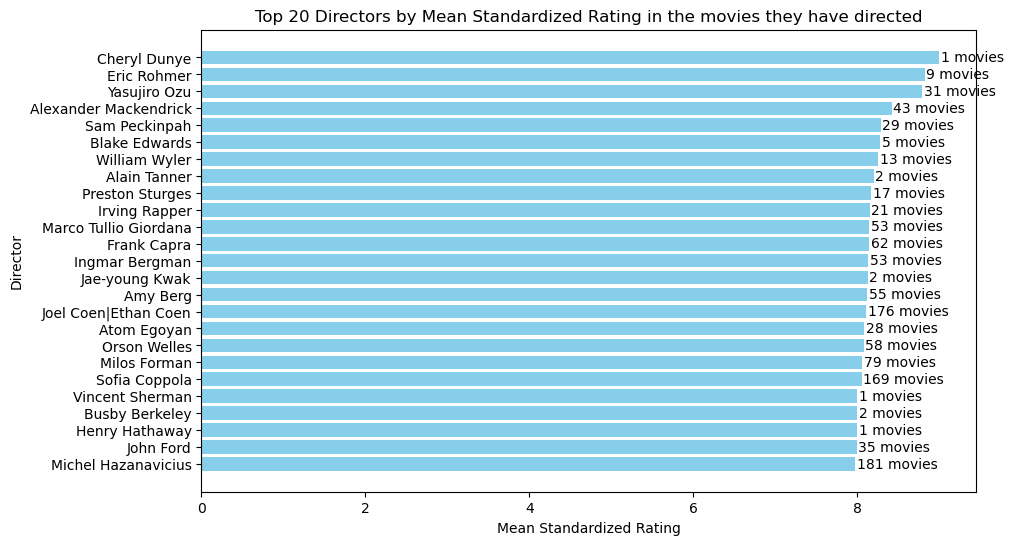

In [53]:
# Take the top 20 directors
top_directors = director_stats_sorted.head(25)

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_directors.index, top_directors['standardized_rating'], color='skyblue')
plt.xlabel('Mean Standardized Rating')
plt.ylabel('Director')
plt.title('Top 20 Directors by Mean Standardized Rating in the movies they have directed')
plt.gca().invert_yaxis()  # To display the director with the highest rating at the top

# Add text labels for 'movie_count' to each bar
for i, bar in enumerate(plt.gca().patches):
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2,
             f"{top_directors['movie_count'].iloc[i]} movies",
             va='center')

plt.show()

In [52]:
#export cleaned datasets

merged_df.to_csv('cleaned_data/merged_df.csv', index=False)

movie_budgets_df.to_csv('cleaned_data/movie_budgets_df.csv', index=False)

imdb_df.to_csv('cleaned_data/imdb_df.csv', index=False)

## CONCLUSION AND RECOMMENDATION

### 1.  Best movies genre for Production

* `Drama:` Based on our data it is highly evident that the drama category is the most popular among viewers with a significantly high number of occurences ie `28394` and a high mean standard rating ie `6.663` compared to the 2nd most popular category, `comedy` with a occurence `15514` and mean of `5.546` meaning `drama` category is more appealing and engaging to a higher audience. 

* Mixed Genres: in Movies that combine genres, it is evident that the combination for  Comedy & Drama, have high a high occurrence of `5358` and rating of `6.742` indicating a successful formula/combination. This shows that movies that blend elements of both comedy and drama are more apealing to a lerger audience. These film offer the best of both worlds providing viewers with a balanced mix of humor and eotional depth. 

### 2. Average production budget

* It is noted that the average production budget for the movies over the years is `$ 31 million` with an average domestic and world_wide revenue of `$ 41 million` and `$ 91 million` respectively.

* Thre is a moderately strong positive correlation between production budget and domestic gross at `0.686`.
* There is a strong positive correlation between prodction budget and worl-wide gross at `0.748`, implying that high budgets have more impact on global earnings, which may reflect in quality directors, advertisemnts, actors.
* There is also a very strong positive correlation between domestic gross and worldwide gross at `0.939`, implying that if a movie succeeds domestically, it will succeed globally.

### 3.Movie length

* From the Findings, there is a very low positive correlation of `0.15` between movie length and the critic-rating, implying that as the movie runtime increases, there is slight tendency for critic rating to increase as well but the relationship is not strong. 

### 4. Recommended director to hire

* the Coen brothers ie Joen Coen and Ethan Coen have directed `176` movies with a rating of `8.105`. This indicates that they are highly respected fil makers with a strong track record of producing quality films. 
* The next recommended director is Sofia Coppola  whose movies have a rating of `8.052129` having directed `169` movies. Her high average rating is essentionally high which suggests that her movies are consistently well received by critics and audiences alike.